# 1 Feedforward Neural Network

In [33]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

train_x, train_y = np.load('train_x.npy'), np.load('train_y.npy')
test_x, test_y = np.load('test_x.npy'), np.load('test_y.npy')

checkpoint = np.load('weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

## 1-1
<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>

Design a FNN model architecture and use the file of the initial weights and biases “<span class="blue">weights.npy</span>”. 

Run the <span class="red">backpropagation</span> algorithm and use the <span class="red">mini-batch SGD</span> (stochastic gradient descent) 
$$
    \mathbf{w}^{(\tau+1)}=\mathbf{w}^{(\tau)}-\eta \nabla J\left(\mathbf{w}^{(\tau)}\right)
$$
to optimize the parameters (<span class="blue">the weights and biases)</span>,
where $\nabla$ is the learning rate. 

<span class="red">You should implement the FNN training under the following settings:</span>

- number of layers: 3
- number of neurons in each layer (in order): 2048, 512, 5
- activation function for each layer (in order): relu, relu, softmax
- number of training epochs: 30
- learning rate: 0.01
- batch size: 200
- **important note**: For 1(a), <span class="red">DO NOT RESHUFFLE THE DATA.</span> We had already shuffled the data for you.

Reshuffling will make <span class="blue">your result differ from our ground-truth result</span>, and <span class="red">any difference will result in reduction of your points.</span>

On the same note, when splitting the samples into batches, split them in the given sample order.

<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>
(a) **Plot** the <span class="blue">learning curves</span> of $J(\mathbf{w})$ and the <span class="blue">accuracy</span> of classification <span class="blue">for every 25 iterations</span>, with training data as well as test data, also, **show** the final loss and accuracy values.

In [34]:
# number of layers: 3
# number of neurons in each layer (in order): 2048, 512, 5
# activation function for each layer (in order): relu, relu, softmax
# number of training epochs: 30
# learning rate: 0.01
# batch size: 200

cache = {}

params = {
        "w1": init_weights[0], # shape: (784, 2048)
        "b1": init_biases[0], # shape: (2048, 1)
        "w2": init_weights[1], # shape: (2048, 512)
        "b2": init_biases[1], # shape: (512, 1)
        "w3": init_weights[2], # shape: (512, 5)
        "b3": init_biases[2] # shape: (5, 1)
}       

# define the activation function
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

def drelu(x):
    return np.where(x > 0, 1, 0)

def cross_entropy_loss(y_hat, y_true):
    """
    y_hat: predicted label, shape: (batch_size, 5)
    y_true: true label, shape: (batch_size, 5)

    cross_entropy_loss = -1/m * np.sum(y_true * np.log(y_hat))
    """
    y_true = np.eye(5)[y_true]
    y_hat = softmax(y_hat)
    return -1/y_true.shape[0] * np.sum(y_true * np.log(y_hat + 1e-8))

def accuracy(y_hat, y_true):
    y_hat = np.argmax(y_hat, axis=1)
    return np.sum(y_hat == y_true) / len(y_true)

def forward(x):
    """
    x: input data, shape: (784, batch_size)
    z = x @ w + b
    a = relu(z)
    """
    cache['x'] = x
    cache['z1'] = cache['x'] @ params['w1'] + params['b1'] # (200, 784) @ (784, 2048) + (2048, 1) = (200, 2048)
    cache['a1'] = relu(cache['z1']) # (200, 2048)
    cache['z2'] = cache['a1'] @ params['w2'] + params['b2'] # (200, 2048) @ (2048, 512) + (512, 1) = (200, 512)
    cache['a2'] = relu(cache['z2']) # (200, 512)
    cache['z3'] = cache['a2'] @ params['w3'] + params['b3'] # (200, 512) @ (512, 5) + (5, 1) = (200, 5)
    cache['a3'] = softmax(cache['z3']) # (200, 5)
    return cache['a3']

def back_propagate(y, y_hat):
    """
    y: true label, shape: (batch_size, 5)
    y_hat: predicted label, shape: (batch_size, 5)
    dz = (1./m) * (y_hat - y)
    dw = a.T @ dz
    """
    y = np.eye(5)[y]
    dz3 = (1./y.shape[0]) * (y_hat - y) # (200, 5)
    dw3 = cache['a2'].T @ dz3 # (512, 200) @ (200, 5) = (512, 5)
    db3 = np.sum(dz3, axis=0).T # (5, 1)
    dz2 = dz3 @ params['w3'].T * drelu(cache['z2']) # (200, 5) @ (5, 512) * (200, 512) = (200, 512)
    dw2 = cache['a1'].T @ dz2 # (2048, 200) @ (200, 512) = (2048, 512)
    db2 = np.sum(dz2, axis=0).T # (512, 1)
    dz1 = dz2 @ params['w2'].T * drelu(cache['z1']) # (200, 512) @ (512, 2048) * (200, 2048) = (200, 2048)
    dw1 = cache['x'].T @ dz1 # (784, 200) @ (200, 2048) = (784, 2048)
    db1 = np.sum(dz1, axis=0).T # (2048, 1)
    
    grads = {
        "w1": dw1,
        "b1": db1,
        "w2": dw2,
        "b2": db2,
        "w3": dw3,
        "b3": db3,
    }
    return grads

In [35]:
epochs = 30
batch_size = 200
learning_rate = 0.01

train_acc, train_loss = [], []
test_acc, test_loss = [], []

# training
with tqdm.tqdm(total=690) as pbar:
    for epoch in range(epochs):
    # use train_x and train_y to train the model
    # use test_x and test_y to evaluate the model

        for i in range(0, len(train_x), batch_size):
            pbar.update(1)
            
            x = train_x[i:i+batch_size]
            y = train_y[i:i+batch_size]
            y_hat = forward(x / 255)
            
            grads = back_propagate(y, y_hat)

            for key in params:
                params[key] -= learning_rate * grads[key]
            
            if (epoch * 23 + i) % 25 == 0:
                train_acc += [accuracy(forward(train_x / 255), train_y)]
                train_loss += [cross_entropy_loss(forward(train_x / 255), train_y)]
                test_acc += [accuracy(forward(test_x / 255), test_y)]
                test_loss += [cross_entropy_loss(forward(test_x / 255), test_y)]
                pbar.postfix = f"train_acc: {train_acc[-1]:.4f}, train_loss: {train_loss[-1]:.4f}, test_acc: {test_acc[-1]:.4f}, test_loss: {test_loss[-1]:.4f}"                        

100%|██████████| 690/690 [00:47<00:00, 14.68it/s, train_acc: 0.9587, train_loss: 0.9461, test_acc: 0.7580, test_loss: 1.1468]


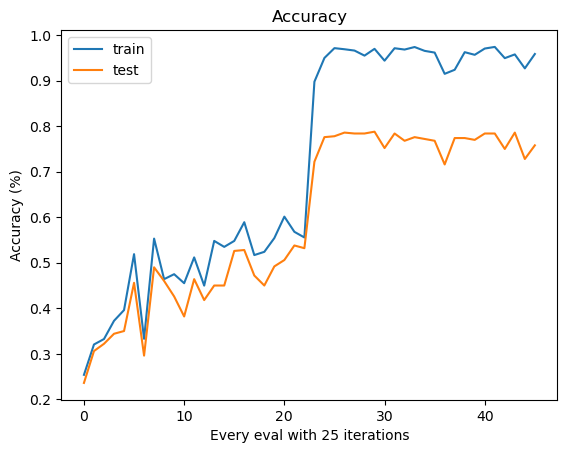

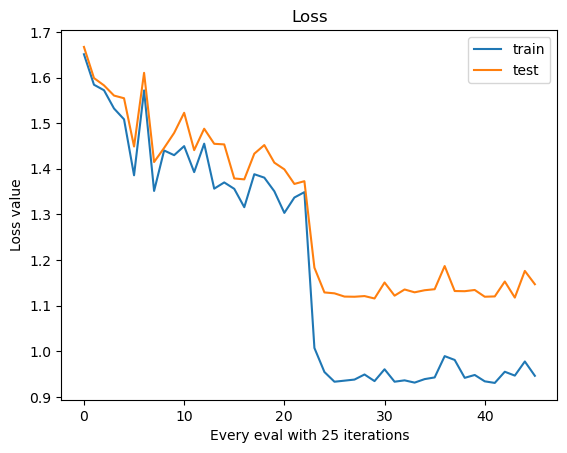

In [36]:
# plot the training and testing accuracy
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('Accuracy')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plot the training and testing loss
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('Loss')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Loss value')
plt.legend()
plt.show()

<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>
(b) **Repeat 1(a)** by considering <span class="red">zero initialization</span> for the model weights. And **make some discussion.**

In [37]:
zero_cache = {}

zero_params = {
    "w1": np.zeros((784, 2048)),
    "b1": np.zeros((2048,)),
    "w2": np.zeros((2048, 512)),
    "b2": np.zeros((512,)),
    "w3": np.zeros((512, 5)),
    "b3": np.zeros((5,)),
}

def zero_forward(x):
    """
    x: input data, shape: (784, batch_size)
    z = x @ w + b
    a = relu(z)
    """
    zero_cache['x'] = x
    zero_cache['z1'] = zero_cache['x'] @ zero_params['w1'] + zero_params['b1'] # (200, 784) @ (784, 2048) + (2048, 1) = (200, 2048)
    zero_cache['a1'] = relu(zero_cache['z1']) # (200, 2048)
    zero_cache['z2'] = zero_cache['a1'] @ zero_params['w2'] + zero_params['b2'] # (200, 2048) @ (2048, 512) + (512, 1) = (200, 512)
    zero_cache['a2'] = relu(zero_cache['z2']) # (200, 512)
    zero_cache['z3'] = zero_cache['a2'] @ zero_params['w3'] + zero_params['b3'] # (200, 512) @ (512, 5) + (5, 1) = (200, 5)
    zero_cache['a3'] = softmax(zero_cache['z3']) # (200, 5)
    return zero_cache['a3']

def zero_back_propagate(y, y_hat):
    """
    y: true label, shape: (batch_size, 5)
    y_hat: predicted label, shape: (batch_size, 5)
    dz = (1./m) * (y_hat - y)
    dw = a.T @ dz
    """
    y = np.eye(5)[y]
    dz3 = (1./y.shape[0]) * (y_hat - y) # (200, 5)
    dw3 = zero_cache['a2'].T @ dz3 # (512, 200) @ (200, 5) = (512, 5)
    db3 = np.sum(dz3, axis=0).T # (5, 1)
    dz2 = dz3 @ zero_params['w3'].T * drelu(zero_cache['z2']) # (200, 5) @ (5, 512) * (200, 512) = (200, 512)
    dw2 = zero_cache['a1'].T @ dz2 # (2048, 200) @ (200, 512) = (2048, 512)
    db2 = np.sum(dz2, axis=0).T # (512, 1)
    dz1 = dz2 @ zero_params['w2'].T * drelu(zero_cache['z1']) # (200, 512) @ (512, 2048) * (200, 2048) = (200, 2048)
    dw1 = zero_cache['x'].T @ dz1 # (784, 200) @ (200, 2048) = (784, 2048)
    db1 = np.sum(dz1, axis=0).T # (2048, 1)
    
    zero_grads = {
        "w1": dw1,
        "b1": db1,
        "w2": dw2,
        "b2": db2,
        "w3": dw3,
        "b3": db3,
    }
    return zero_grads

In [38]:
zero_train_acc, zero_train_loss = [], []
zero_test_acc, zero_test_loss = [], []

with tqdm.tqdm(total=690) as pbar:
    for epoch in range(epochs):
        # use train_x and train_y to train the model
        # use test_x and test_y to evaluate the model

        for i in range(0, len(train_x), batch_size):
            pbar.update(1)
            x = train_x[i:i+batch_size]
            y = train_y[i:i+batch_size]
            y_hat = zero_forward(x / 255)
            
            zero_grads = zero_back_propagate(y, y_hat)

            for key in params:
                zero_params[key] -= learning_rate * zero_grads[key]
            
            if (epoch * 23 + i) % 25 == 0:
                zero_train_acc += [accuracy(zero_forward(train_x / 255), train_y)]
                zero_train_loss += [cross_entropy_loss(zero_forward(train_x / 255), train_y)]
                zero_test_acc += [accuracy(zero_forward(test_x / 255), test_y)]
                zero_test_loss += [cross_entropy_loss(zero_forward(test_x / 255), test_y)]
                pbar.postfix = f"train_acc: {zero_train_acc[-1]:.4f}, train_loss: {zero_train_loss[-1]:.4f}, test_acc: {zero_test_acc[-1]:.4f}, test_loss: {zero_test_loss[-1]:.4f}"

100%|██████████| 690/690 [00:36<00:00, 18.75it/s, train_acc: 0.2000, train_loss: 1.6094, test_acc: 0.2000, test_loss: 1.6094]


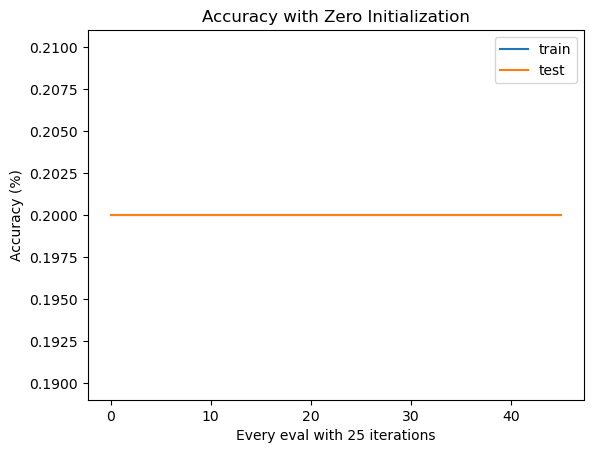

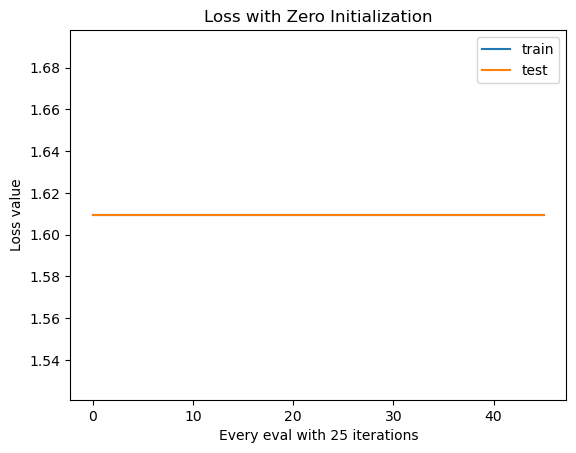

In [39]:
# plot the training and testing accuracy
plt.plot(zero_train_acc, label='train')
plt.plot(zero_test_acc, label='test')
plt.title('Accuracy with Zero Initialization')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plot the training and testing loss
plt.plot(zero_train_loss, label='train')
plt.plot(zero_test_loss, label='test')
plt.title('Loss with Zero Initialization')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Loss value')
plt.legend()
plt.show()

## 1-2
<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>

Based on the model in 1, please <span class="blue">implement the dropout layers</span> and apply them <span class="blue">after the first two hidden layers</span>, i.e. the layers with 2048 and 512 neurons. 

The <span class="blue">dropout rate should be set as 0.2</span> for both layers. 

Note that the dropout operation <span class="blue">should only be applied in the training phase</span> and should be disabled in the test phase.

(a) **Train** the model by using the same settings in 1 and **repeat 1(a).**

In [40]:
checkpoint = np.load('weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

In [41]:
params = {
        "w1": init_weights[0], # shape: (784, 2048)
        "b1": init_biases[0], # shape: (2048, 1)
        "w2": init_weights[1], # shape: (2048, 512)
        "b2": init_biases[1], # shape: (512, 1)
        "w3": init_weights[2], # shape: (512, 5)
        "b3": init_biases[2] # shape: (5, 1)
}      

In [42]:
def dropout_forward(x):
    """
    x: input data, shape: (784, batch_size)
    z = x @ w + b
    a = relu(z)
    """
    cache['x'] = x
    cache['z1'] = cache['x'] @ params['w1'] + params['b1'] # (200, 784) @ (784, 2048) + (2048, 1) = (200, 2048)

    # dropout with probability 0.2 and use the mask to scale the output with numpy
    mask = np.random.rand(*cache['z1'].shape) < 0.8
    cache['z1'] = cache['z1'] * mask / 0.8

    cache['a1'] = relu(cache['z1']) # (200, 2048)
    cache['z2'] = cache['a1'] @ params['w2'] + params['b2'] # (200, 2048) @ (2048, 512) + (512, 1) = (200, 512)

    mask = np.random.rand(*cache['z2'].shape) < 0.8
    cache['z2'] = cache['z2'] * mask / 0.8

    cache['a2'] = relu(cache['z2']) # (200, 512)
    cache['z3'] = cache['a2'] @ params['w3'] + params['b3'] # (200, 512) @ (512, 5) + (5, 1) = (200, 5)

    mask = np.random.rand(*cache['z3'].shape) < 0.8
    cache['z3'] = cache['z3'] * mask / 0.8

    cache['a3'] = softmax(cache['z3']) # (200, 5)
    return cache['a3']

def deropout_back_propagate(y, y_hat):
    """
    y: true label, shape: (batch_size, 5)
    y_hat: predicted label, shape: (batch_size, 5)
    dz = (1./m) * (y_hat - y)
    dw = a.T @ dz
    """
    y = np.eye(5)[y]
    dz3 = (1./y.shape[0]) * (y_hat - y) # (200, 5)
    dw3 = cache['a2'].T @ dz3 # (512, 200) @ (200, 5) = (512, 5)
    db3 = np.sum(dz3, axis=0).T # (5, 1)
    dz2 = dz3 @ params['w3'].T * drelu(cache['z2']) # (200, 5) @ (5, 512) * (200, 512) = (200, 512)
    dw2 = cache['a1'].T @ dz2 # (2048, 200) @ (200, 512) = (2048, 512)
    db2 = np.sum(dz2, axis=0).T # (512, 1)
    dz1 = dz2 @ params['w2'].T * drelu(cache['z1']) # (200, 512) @ (512, 2048) * (200, 2048) = (200, 2048)
    dw1 = cache['x'].T @ dz1 # (784, 200) @ (200, 2048) = (784, 2048)
    db1 = np.sum(dz1, axis=0).T # (2048, 1)
    
    grads = {
        "w1": dw1,
        "b1": db1,
        "w2": dw2,
        "b2": db2,
        "w3": dw3,
        "b3": db3,
    }
    return grads

In [43]:
drop_train_acc, drop_train_loss = [], []
drop_test_acc, drop_test_loss = [], []

with tqdm.tqdm(total=690) as pbar:
    # training
    for epoch in range(epochs):
        # use train_x and train_y to train the model
        # use test_x and test_y to evaluate the model

        for i in range(0, len(train_x), batch_size):
            pbar.update(1)
            x = train_x[i:i+batch_size]
            y = train_y[i:i+batch_size]
            y_hat = dropout_forward(x / 255)
            
            grads = deropout_back_propagate(y, y_hat)

            for key in params:
                params[key] -= learning_rate * grads[key]
            
            if (epoch * 23 + i) % 25 == 0:
                drop_train_acc += [accuracy(dropout_forward(train_x / 255), train_y)]
                drop_train_loss += [cross_entropy_loss(dropout_forward(train_x / 255), train_y)]
                drop_test_acc += [accuracy(dropout_forward(test_x / 255), test_y)]
                drop_test_loss += [cross_entropy_loss(dropout_forward(test_x / 255), test_y)]
                pbar.postfix = f"train_acc: {drop_train_acc[-1]:.4f}, train_loss: {drop_train_loss[-1]:.4f}, test_acc: {drop_test_acc[-1]:.4f}, test_loss: {drop_test_loss[-1]:.4f}"

100%|██████████| 690/690 [01:00<00:00, 11.48it/s, train_acc: 0.6893, train_loss: 1.2150, test_acc: 0.6500, test_loss: 1.2731]


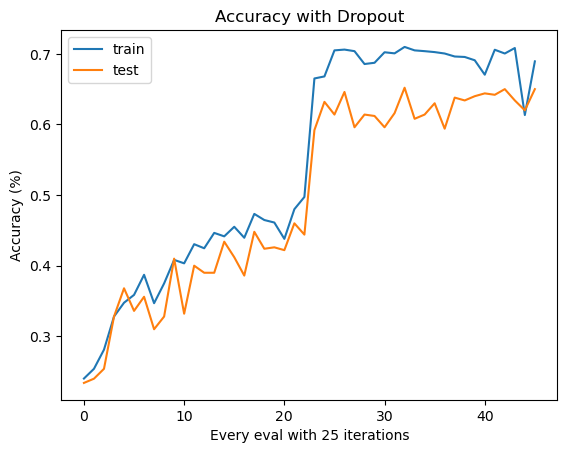

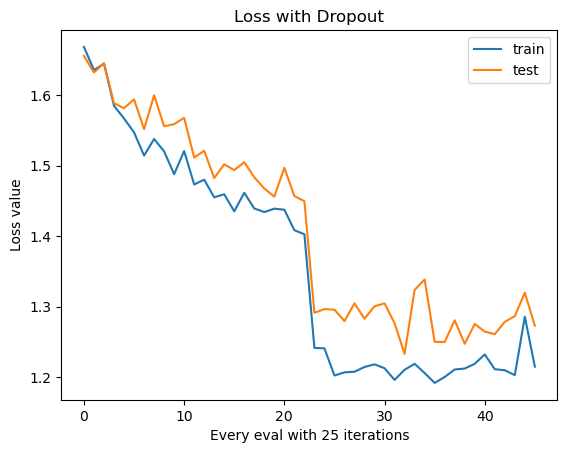

In [44]:
# plot the training and testing accuracy
plt.plot(drop_train_acc, label='train')
plt.plot(drop_test_acc, label='test')
plt.title('Accuracy with Dropout')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plot the training and testing loss
plt.plot(drop_train_loss, label='train')
plt.plot(drop_test_loss, label='test')
plt.title('Loss with Dropout')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Loss value')
plt.legend()
plt.show()

(b) Based on the experimental results, how the dropout layers affect the model performance and why? Please **make some discussion.**

## 1-3

Based on the model in 1, please implement mini-batch SGD (stochastic gradient descent).

In this problem, we need to reshuffle the data in every batch. Note that the other settings remain the same. 

Please set the random seed as **42**, and please use **random** library that we have imported.

<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>

(a) **Plot** the <span class="blue">learning curves</span> of $J(\mathbf{w})$ and the classification <span class="blue">accuracy for every 25 iterations.</span> Please **show** the final values of loss and accuracy.

In [45]:
checkpoint = np.load('weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

In [46]:
params = {
        "w1": init_weights[0], # shape: (784, 2048)
        "b1": init_biases[0], # shape: (2048, 1)
        "w2": init_weights[1], # shape: (2048, 512)
        "b2": init_biases[1], # shape: (512, 1)
        "w3": init_weights[2], # shape: (512, 5)
        "b3": init_biases[2] # shape: (5, 1)
}      

In [47]:
sgd_train_acc, sgd_train_loss = [], []
sgd_test_acc, sgd_test_loss = [], []

np.random.seed(42)

with tqdm.tqdm(total=690) as pbar:
    # training
    for epoch in range(epochs):

        for i in range(0, len(train_x), batch_size):
            # reshuffle the data with the same seed 42
            pbar.update(1)
            x = train_x[i:i+batch_size]
            y = train_y[i:i+batch_size]

            shuffle_idx = np.random.permutation(len(x))
            x = x[shuffle_idx]
            y = y[shuffle_idx]
            
            # np.random.shuffle(x)
            # np.random.shuffle(y)

            y_hat = forward(x / 255)
            
            grads = back_propagate(y, y_hat)

            for key in params:
                params[key] -= learning_rate * grads[key]
            
            if (epoch * 23 + i) % 25 == 0:
                sgd_train_acc += [accuracy(forward(train_x / 255), train_y)]
                sgd_train_loss += [cross_entropy_loss(forward(train_x / 255), train_y)]
                sgd_test_acc += [accuracy(forward(test_x / 255), test_y)]
                sgd_test_loss += [cross_entropy_loss(forward(test_x / 255), test_y)]
                pbar.postfix = f"train_acc: {sgd_train_acc[-1]:.4f}, train_loss: {sgd_train_loss[-1]:.4f}, test_acc: {sgd_test_acc[-1]:.4f}, test_loss: {sgd_test_loss[-1]:.4f}"


100%|██████████| 690/690 [00:47<00:00, 14.64it/s, train_acc: 0.9598, train_loss: 0.9453, test_acc: 0.7780, test_loss: 1.1253]


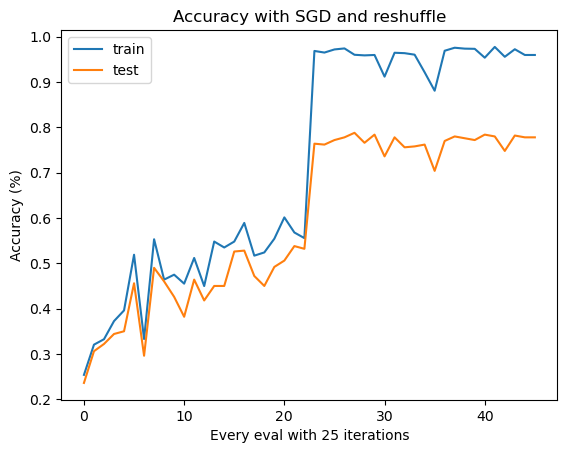

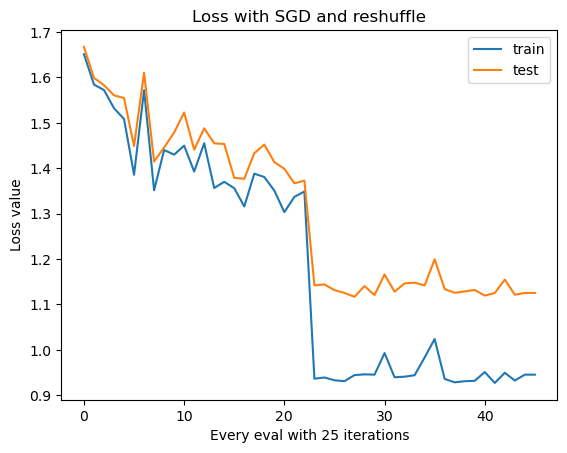

In [48]:
# plot the training and testing accuracy
plt.plot(sgd_train_acc, label='train')
plt.plot(sgd_test_acc, label='test')
plt.title('Accuracy with SGD and reshuffle')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

# plot the training and testing loss
plt.plot(sgd_train_loss, label='train')
plt.plot(sgd_test_loss, label='test')
plt.title('Loss with SGD and reshuffle')
plt.xlabel('Every eval with 25 iterations')
plt.ylabel('Loss value')
plt.legend()
plt.show()

<style>
    .red {
        color: red;
    }
    .blue {
        color: skyblue;
    }
</style>

(b) Based on the experimental results, how the <span class="blue">process of reshuffling images</span> affects the model performance and why? Please **make some discussion.**